## Load a  previously trained doc2vec model

The model was trained using gensim with the following parameters

In [1]:
import umap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from gensim.models import Doc2Vec

%matplotlib inline

In [2]:
# You will first need to unzip the file
model = Doc2Vec.load('imdb.d2v')

## As a test case we are only going to take the training set of positive and negative documents

In [3]:
positive_examples = []
negative_examples = []
for i, x in enumerate(model.docvecs.doctags):
    if x.startswith('TRAIN_POS'):
        positive_examples.append(model.docvecs[i])
    if x.startswith('TRAIN_NEG'):
        negative_examples.append(model.docvecs[i])

In [4]:
pos = pd.DataFrame(positive_examples)
pos.insert(loc=0, column='sentiment', value=1)

neg = pd.DataFrame(negative_examples)
neg.insert(loc=0, column='sentiment', value=0)
reviews = pd.concat([pos, neg], ignore_index=True)

### Let's try to embed the documents which are embedded into a 100 dimensional space into a two dimensional space

In [38]:
%%time
review_array = np.array(reviews.iloc[:, 1:])
review_embedding = umap.UMAP().fit_transform(review_array)

CPU times: user 6min 13s, sys: 988 ms, total: 6min 14s
Wall time: 4min 44s


In [39]:
df = pd.DataFrame(review_embedding, columns=['x', 'y'])
df['labels'] = reviews['sentiment']

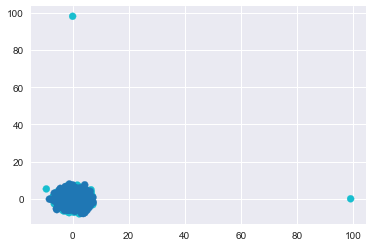

In [40]:
plt.scatter(x=df['x'], y=df['y'], c=df['labels'], cmap='tab10')

This doesn't look great. Let's try decreasing the size of the local neighborhood and increasing min_dist

In [51]:
%%time
tweaked_embedding = umap.UMAP(n_neighbors=10, min_dist=1.0).fit_transform(review_array)

CPU times: user 4min 24s, sys: 364 ms, total: 4min 24s
Wall time: 3min 28s


In [53]:
df2 = pd.DataFrame(tweaked_embedding, columns=['x', 'y'])
df2['labels'] = reviews['sentiment']

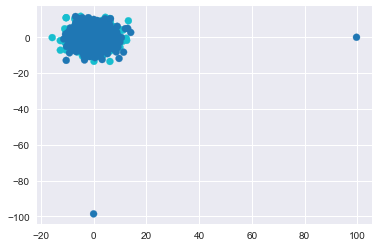

In [55]:
plt.scatter(x=df2['x'], y=df2['y'], 
            c=df2['labels'], cmap='tab10')

It still looks basically the same. If we zoom in (to ignore the outlying points) we see

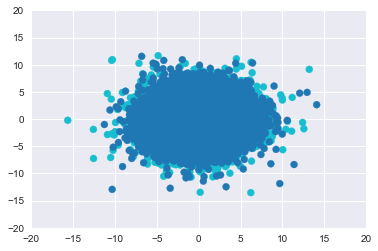

In [56]:
plt.axis([-20, 20, -20, 20])
plt.scatter(x=df2['x'], y=df2['y'], c=df2['labels'], cmap='tab10')

### Let's try PCA

In [3]:
from sklearn.decomposition import PCA

In [11]:
%%time
review_array = np.array(reviews.iloc[:, 1:])
pca_embedding = PCA(n_components=2).fit_transform(review_array)

CPU times: user 264 ms, sys: 8 ms, total: 272 ms
Wall time: 157 ms


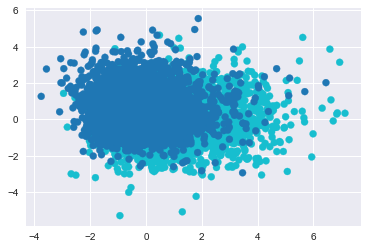

In [12]:
pca_df = pd.DataFrame(pca_embedding, columns=['x', 'y'])
pca_df['labels'] = reviews['sentiment']

plt.scatter(x=pca_df['x'], y=pca_df['y'], c=pca_df['labels'], cmap='tab10')

### Let's try it without the spectral initialization

In [5]:
%%time
review_array = np.array(reviews.iloc[:, 1:])
review_embedding = umap.UMAP(init='random').fit_transform(review_array)

CPU times: user 3min 1s, sys: 352 ms, total: 3min 1s
Wall time: 3min 1s


In [7]:
random_embedding = review_embedding

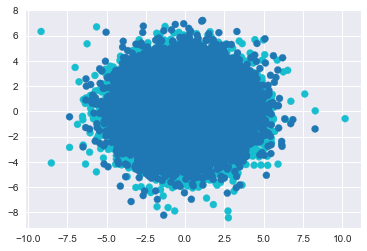

In [8]:
random_df = pd.DataFrame(random_embedding, columns=['x', 'y'])
random_df['labels'] = reviews['sentiment']

plt.scatter(x=random_df['x'], y=random_df['y'], c=random_df['labels'], cmap='tab10')

In [9]:
umap.__file__

'/home/gclenden/anaconda3/lib/python3.6/site-packages/umap-0.0.1-py3.6-linux-x86_64.egg/umap/__init__.py'

### Let's try looking into why this didn't work

In [34]:
import numpy as np
from scipy.sparse import find
from umap.umap_utils import fuzzy_simplicial_set

In [15]:
u = umap.UMAP()

In [17]:
print(u.n_neighbors)
print(u.oversampling)

50
3


In [19]:
%%time
graph = fuzzy_simplicial_set(review_array, u.n_neighbors, u.oversampling)

CPU times: user 1min 24s, sys: 116 ms, total: 1min 24s
Wall time: 1min 24s


In [32]:
row_idx, col_idx, non_zero_val = find(graph)

In [59]:
logs = np.log(non_zero_val)
sorted(logs)

[-182.76703723076869,
 -182.76703723076869,
 -155.61499637503186,
 -155.61499637503186,
 -132.17115218684077,
 -132.17115218684077,
 -121.72089185206474,
 -121.72089185206474,
 -120.62853971293048,
 -120.62853971293048,
 -119.42351710640956,
 -119.42351710640956,
 -118.06674479569836,
 -118.06674479569836,
 -115.82457962375778,
 -115.82457962375778,
 -114.40917546049887,
 -114.40917546049887,
 -112.74276101187854,
 -112.74276101187854,
 -111.45909513242631,
 -111.45909513242631,
 -110.80671431346163,
 -110.80671431346163,
 -109.84968350614497,
 -109.84968350614497,
 -109.63008147114049,
 -109.63008147114049,
 -109.5757808450868,
 -109.5757808450868,
 -109.4795346279987,
 -109.4795346279987,
 -109.11587072471065,
 -109.11587072471065,
 -107.25187171228663,
 -107.25187171228663,
 -105.54299282710988,
 -105.54299282710988,
 -105.53656502373077,
 -105.53656502373077,
 -104.81966846271192,
 -104.81966846271192,
 -104.51705211744323,
 -104.51705211744323,
 -101.96537283487224,
 -101.96537283

In [106]:
logs_df = pd.DataFrame(sorted(logs))

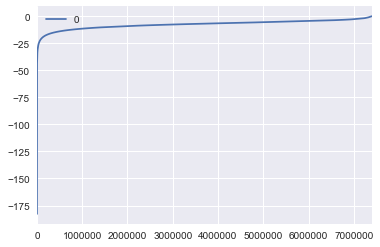

In [108]:
logs_df.plot()

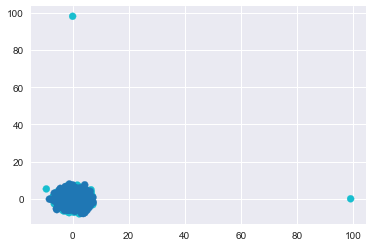

In [41]:
# Taking a look at the embedding again
df = pd.DataFrame(review_embedding, columns=['x', 'y'])
df['labels'] = reviews['sentiment']
plt.scatter(x=df['x'], y=df['y'], c=df['labels'], cmap='tab10')

Looking for the outlying ones

In [44]:
df[(df.x > 80) | (df.y > 80)] 

,x,y,labels
1751,98.998522,0.007130,1
2483,0.011736,98.216747,1


In [47]:
outlier_row_1 = graph[1751, :]
outlier_col_1 = graph[:, 1751]

outlier_row_2 = graph[2483, :]
outlier_col_2 = graph[:, 2483]

In [77]:
def get_logs_of_non_zero(v):
    i, j, k = find(v)
    return np.log(k)

In [80]:
row_1_logs = get_logs_of_non_zero(outlier_row_1)
col_1_logs = get_logs_of_non_zero(outlier_col_1)

row_2_logs = get_logs_of_non_zero(outlier_row_2)
col_2_logs = get_logs_of_non_zero(outlier_col_2)

### Let's look at the outlying row distributions

In [103]:
sorted(row_1_logs)[:10]

[-121.72089185206474,
 -120.62853971293048,
 -118.06674479569836,
 -115.82457962375778,
 -114.40917546049887,
 -112.74276101187854,
 -110.80671431346163,
 -109.63008147114049,
 -109.4795346279987,
 -105.53656502373077]

In [102]:
sorted(row_2_logs)[:10]

[-182.76703723076869,
 -155.61499637503186,
 -111.45909513242631,
 -109.84968350614497,
 -109.5757808450868,
 -109.11587072471065,
 -104.51705211744323,
 -99.757132353921378,
 -96.433267756684558,
 -91.417401193614552]

Picking random rows

In [105]:
rand_ints = np.random.randint(graph.shape[0], size=10)
for r in rand_ints:
    row_logs = get_logs_of_non_zero(graph[r, :])
    col_logs = get_logs_of_non_zero(graph[:, r])
    
    print('Top 10 values of row {}'.format(r))
    print(sorted(row_logs)[:10])

Top 10 values of row 13294
[-17.647719931089348, -16.719463363896093, -16.399787350007774, -16.394554000585664, -16.061055366323178, -15.983542014369188, -15.589802920356556, -15.393751995816006, -14.819123661464554, -14.794492960408853]
Top 10 values of row 23701
[-22.106675481114149, -21.742645096840938, -17.482367490025009, -16.152028930589609, -15.806665220384867, -15.76284545822922, -14.873900722291518, -14.361575454195519, -13.732103081932046, -13.499198209696276]
Top 10 values of row 5332
[-20.705514882766529, -14.999716820855555, -14.530156560886741, -14.379879745197625, -14.309015863457779, -12.249114475336517, -11.757046953190208, -11.627936364645517, -11.171694667042717, -10.74493496434053]
Top 10 values of row 7676
[-16.797223733069799, -16.646816333393961, -15.684379186385122, -15.590805657698843, -14.759392629305275, -13.076956007953662, -12.989904224158789, -12.703244285086072, -12.099902290658584, -12.07369052066027]
Top 10 values of row 18152
[-26.193783734737433, -25.

So it appears the logs of the outlying rows are much bigger than normal. Not sure what this means